In [ ]:
import sys
sys.path.append('../')

In [ ]:
from pathlib import Path
import cv2, logging as l
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as TF
from fastai.vision.all import *
from src.unet import UNet2DModel

In [ ]:
path = Path('../data')

In [ ]:
def read_yolo(file):
    res = []
    with open(file, 'r') as f:
        for l in f: res.append(np.array(l.split()[1:], dtype=np.float32).reshape(-1,2))
    return res

def create_mask(img_shape, labels):
    res = np.zeros(img_shape, dtype=np.uint8)
    h,w = img_shape
    for mask in labels: res = cv2.fillPoly(res, [(mask*(w,h)).astype(np.int32)], 255)
    return res

In [ ]:
@ItemTransform
def mask_tfm(item):
    x, y = item
    y = create_mask(x.shape, y).astype(np.float32)
    return x, TensorMask(y/255.)

@Transform
def gamma_tfm(x: TensorImage|TensorImageBW, gamma=0.8):
    return x**gamma

In [ ]:
dblock = DataBlock(blocks=(ImageBlock(PILImageBW), TransformBlock(batch_tfms=IntToFloatTensor())),
                   get_items=lambda p: get_image_files(p, folders=['valid','train']),
                   get_y=lambda o: read_yolo(str(o).replace('images', 'labels').replace('jpg','txt')),
                   splitter=GrandparentSplitter(valid_name='valid'),
                   item_tfms=[mask_tfm],
                   batch_tfms=[gamma_tfm, *aug_transforms(size=256, min_scale=0.75, max_lighting=0.2)])

In [ ]:
dls = dblock.dataloaders(path, bs=4)

In [ ]:
b = dls.one_batch()

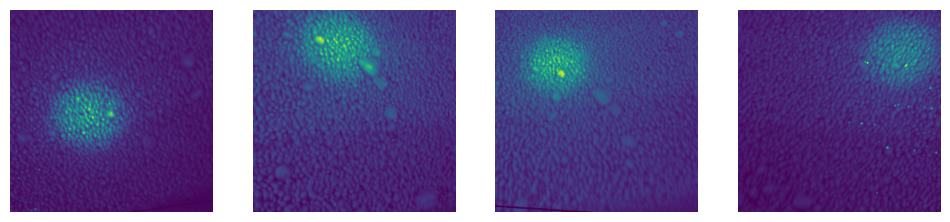

In [ ]:
show_images(b[0])

## U-net

In [ ]:
model = UNet2DModel()

In [ ]:
dls = dblock.dataloaders(path, bs=8)
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=[])

epoch,train_loss,valid_loss,time
0,0.283402,0.220771,00:13
1,0.127872,0.081219,00:13
2,0.073151,0.051012,00:13
3,0.051022,0.042545,00:13
4,0.041496,0.048038,00:13
5,0.037873,0.035650,00:13
6,0.036268,0.044966,00:13
7,0.033702,0.032971,00:13
8,0.032807,0.034854,00:13
9,0.031714,0.030763,00:13


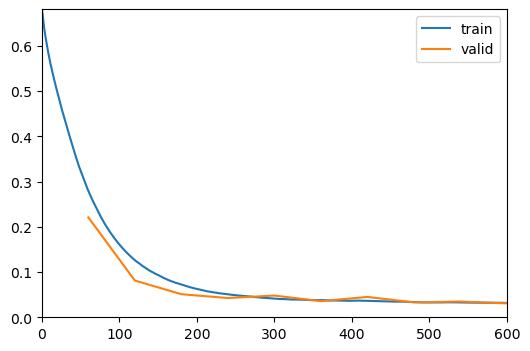

In [ ]:
learn.fit(10, cbs = [ShowGraphCallback(), MixedPrecision()])

In [ ]:
torch.save(model, '../models/unet.pt')

## Inference

In [ ]:
model = torch.load('../models/unet.pt')

In [ ]:
image = cv2.imread('../data/images/clodding_train_005.jpg')

In [ ]:
class ImageProcessor:
    '''Encodes image into tensor, decodes back into image and applies different image effects'''
    def __init__(self, gamma=0.8):
        self.gamma = gamma
        self.tfms = Pipeline([ToTensor(), IntToFloatTensor(), TF.Resize((256, 256))])
    
    def encode(self, image):
        res = self.tfms(PILImageBW.create(image))[0]
        return gamma_tfm(res, gamma=self.gamma)

    def decode(self, tensor):
        tensor = (tensor*255).numpy().astype(np.uint8)
        return cv2.cvtColor(tensor, cv2.COLOR_GRAY2BGR)
    
    def add_texts(self, image, texts, coords, size=1, color=(255,0,0), thickness=1):
        '''Place texts at coordinets'''
        image = image.copy()
        for i, t in enumerate(texts):
            image = cv2.putText(image, str(t), tuple(coords[i]), cv2.FONT_HERSHEY_SIMPLEX,
                                size, color, thickness, cv2.LINE_AA) 
        return image

    def merge_with_mask(self, image, mask, p=0.2, gamma=0):
        '''Merge together original image and segmentation mask'''
        mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)*np.array([0,1,0], np.uint8)
        return cv2.addWeighted(image, 1-p, mask_color, p, gamma)

class MaskProcessor:
    '''Applies postprocessing to output tensor to get final mask and stats'''
    def _init_(self): pass
    
    def decode_mask(self, pred, ths=0.5):
        mask = torch.sigmoid(pred[0]).cpu()[0]
        return IntToFloatTensor().decodes(mask>ths).numpy().astype(np.uint8)
    
    def detach_blobs(self, mask, scale=2):
        kernel = np.ones((scale, scale), np.uint8)
        mask = cv2.erode(mask,kernel,iterations = 1)
        return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    def get_components(self, mask, area_ths = 0.1):
        _, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
        #cast to normal types
        stats = stats.astype(np.float32)
        centroids = centroids.astype(np.int32)
        labels = labels.astype(np.uint8)
        # get normalized resolution-independent areas multiplied by 100 for convenience
        stats[:,cv2.CC_STAT_AREA] /= math.prod(mask.shape)/100
        mask = (stats[:,cv2.CC_STAT_AREA]>area_ths).nonzero()
        labels[~np.isin(labels, mask)]=0
        labels[labels!=0]=255
        # [1:] to not take the background (thank you opencv...)
        return labels, stats[mask][1:], centroids[mask][1:]

In [ ]:
#TODO fix unet for arbitrary sizes
proc = ImageProcessor()
inp = proc.encode(image)
res = model(to_device(inp[None,None]))
out = proc.decode(inp)

In [ ]:
m_proc = MaskProcessor()
mask = m_proc.decode_mask(res, 0.6)
mask = m_proc.detach_blobs(mask, 2)
labels, stats, centroids = m_proc.get_components(mask, 0.0)

In [ ]:
out = proc.merge_with_mask(out, labels)
out = proc.add_texts(out, stats[:,cv2.CC_STAT_AREA].round(2), centroids, 0.3)
out = proc.add_texts(out, [f'total: {len(stats)}', f'biggest: {str(round(stats[:,cv2.CC_STAT_AREA].max(),2))}'], [(2,10), (2, 25)], 0.4)

<Axes: >

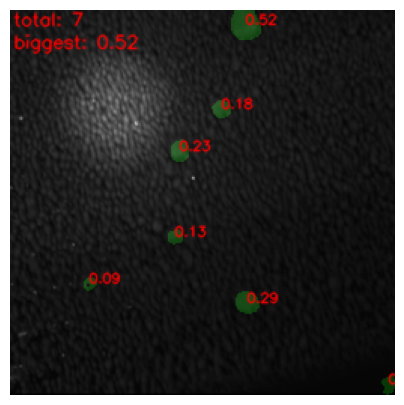

In [ ]:
show_image(out)

In [ ]:
def segment_frame(frame):
    area_ths, blob_scale, prob_ths, gamma, mask_prop = 0.1, 2, 0.5, 20, 0.5
    # encode and prepare
    proc = ImageProcessor()
    inp = proc.encode(frame)
    out = proc.decode(inp)
    # predict
    res = model(to_device(inp[None,None]))
    # prepare mask
    m_proc = MaskProcessor()
    mask = m_proc.decode_mask(res, prob_ths)
    mask = m_proc.detach_blobs(mask, blob_scale)
    labels, stats, centroids = m_proc.get_components(mask, area_ths)
    # merge and add texts
    out = proc.merge_with_mask(out, labels, mask_prop, gamma)
    out = proc.add_texts(out, stats[:,cv2.CC_STAT_AREA].round(2), centroids, 0.3)
    return out, stats

In [ ]:
res, stats = segment_frame(image)

### Tracking

In [ ]:
def calculate_iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    intersection_area = max(0,  min(x1 + w1, x2 + w2) - max(x1, x2)) * \
                        max(0,  min(y1 + h1, y2 + h2) -  max(y1, y2))
    
    union_area =  w1 * h1 + w2 * h2 - intersection_area
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def bbox_from_stats(stats):
    indices = cv2.CC_STAT_LEFT,  cv2.CC_STAT_TOP, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT
    return stats[:,(indices)].astype(np.int64)

def is_overlapping(new_bbox, existing_bboxes, threshold=0.01):
    for bbox in existing_bboxes:
        iou = calculate_iou(new_bbox, bbox)
        if iou > threshold:
            l.debug(f'boxes are overlapping with iou: {iou}')
            return True
    l.debug(f'boxes are not overlapping')
    return False

In [ ]:
bboxes = bbox_from_stats(stats)

In [ ]:
is_overlapping(bboxes[0], bboxes[1:])

2024-04-24 00:38:22 - root - DEBUG - boxes are not overlapping


False

In [ ]:
def draw_bboxes(image, bboxes, col=(0,255,255)):
    image = image.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        image = cv2.rectangle(image, (x, y), (x + w, y + h), col, 2)
    return image

def create_tracker():
    return cv2.TrackerKCF_create()

def init_trackers(image, bboxes):
    #TODO THIS TRACKERS ARE UNSTABLE
    trackers = [create_tracker() for _ in bboxes]
    for tracker, bbox in zip(trackers, bboxes):
        tracker.init(image, tuple(bbox))
    return trackers

def update_bboxes(trackers, frame):
    '''updates bboxes based on trackers and returns tuple with trackers and new bboxes'''
    new_bboxes, left_trackers = [], []
    for tr in trackers:
        success, bbox = tr.update(frame)
        if not success: continue
        new_bboxes.append(bbox)
        left_trackers.append(tr)
    return trackers, new_bboxes

In [ ]:
image2 = cv2.imread('../data/images/clodding_train_006.jpg')

In [ ]:
res, stats = segment_frame(image)
res2, stats2 = segment_frame(image2)

In [ ]:
trackers = init_trackers(res, bbox_from_stats(stats))

In [ ]:
trackers, bboxes = update_bboxes(trackers, res2)

## Real-time

In [ ]:
model = torch.load('../models/unet.pt')

In [ ]:
from IPython.display import display, Image
from itertools import count

def add_labels(image, stats, top_id):
    texts = [f'total: {len(stats)}', 
             f'biggest: {str(round(stats[:,cv2.CC_STAT_AREA].max(),2))}',
             f'top_id: {str(top_id)}']
    l.info(' | '.join(texts))
    image = proc.add_texts(image, texts, [(2,10), (2, 25), (2, 40)], 0.4)
    return image


def process_and_display(file, func=None, tracking = False):
    if func is None:  func = lambda x: x

    video = cv2.VideoCapture(file)
    display_handle = display(None, display_id=True)
    try:
        # read first frame to init trackers
        _, frame = video.read()
        out, stats = func(frame)
        l.info(f'detected {len(stats)} objects')
        total_bboxes = bbox_from_stats(stats)
        trackers = init_trackers(out, total_bboxes)
        l.info(f'found {len(total_bboxes)} new objects')
        top_id = len(trackers)-1
        l.debug(f'init top_id {top_id}')
        out = draw_bboxes(out, total_bboxes)
        out = add_labels(out, stats, top_id)
        
        # start video loop
        for i in count():
            l.debug(f"frame: {i}")
            # draw latest frame
            _, frame = cv2.imencode('.jpeg', cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
            display_handle.update(Image(data=frame.tobytes(), width=500, height=400))
            
            _, frame = video.read()
            if frame is None: break
            out, stats = func(frame)
            l.info(f'detected {len(stats)} objects')
            
            # update existing trackers and possibly remove unsuccessful (whatever it means, thank you opencv, again...)
            trackers, old_bboxes = update_bboxes(trackers, out)
            # if tracker got broken, try to take boxes from previous frame
            if not old_bboxes: old_bboxes = total_bboxes
            l.info(f'found {len(old_bboxes)} old objects')
            
            # add new trackers
            new_bboxes = []
            for b in bbox_from_stats(stats):
                if is_overlapping(b, old_bboxes): continue
                new_bboxes.append(b)
            l.info(f'found {len(new_bboxes)} new objects')
            
            trackers += init_trackers(out, new_bboxes)
            l.debug(f'old top_id {top_id}')
            top_id += len(new_bboxes)
            l.debug(f'new top_id {top_id}')
            total_bboxes = old_bboxes+new_bboxes
            
            out = draw_bboxes(out, old_bboxes)
            out = draw_bboxes(out, new_bboxes, col=(255,255,0))
            out = add_labels(out, stats, top_id)

    except KeyboardInterrupt:
        print('Get keyboard interrupt')
    finally:
        video.release()

In [ ]:
from src.utils import init_logger

init_logger()

In [ ]:
out = process_and_display('../data/clods.mp4', segment_frame)